In [1]:
# ! conda install scikit-learn
# ! conda install tensorflow
# ! pip3 install sklearn
# ! pip3 install -U scikit-learn scipy matplotlib
# ! pip3 install np_utils
# ! pip3 install scipy==1.10 

In [2]:
# ! pip3 uninstall scipy -y
# ! pip3 install scipy==1.1.0 

In [6]:
! pip3 install 'h5py==2.10.0' --force-reinstall


     |████████████████████████████████| 3.0 MB 704 kB/s 
     |████████████████████████████████| 16.8 MB 1.2 MB/s 
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: h5py
    Found existing installation: h5py 3.2.1
    Uninstalling h5py-3.2.1:
      Successfully uninstalled h5py-3.2.1


In [3]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.utils.np_utils import to_categorical
from keras.models import Model,model_from_json
 
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
    
import pandas as pd
from csv import reader


Using TensorFlow backend.


In [4]:
train=pd.read_csv("train.csv")
# test=pd.read_csv("./Data/Test/test.csv")
train_path="./Data/Train/Images/"
test_path="./Data/Test/Images/"

train_img=[]
for i in range(len(train)):
    temp_img=image.load_img(train_path+str(train['filename'][i])+".jpg",target_size=(224,224))
    temp_img=image.img_to_array(temp_img)
    train_img.append(temp_img)

train_img=np.array(train_img)
train_img=preprocess_input(train_img)

In [14]:
def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):
    model = VGG16(weights='imagenet', include_top=True)
    model.layers.pop()
    model.outputs = [model.layers[-1].output]
    model.layers[-1].outbound_nodes = []
    x=Dense(num_classes, activation='softmax')(model.output)
    model=Model(model.input,x)

    #To set the first 8 layers to non-trainable (weights will not be updated)
    for layer in model.layers[:8]:
       layer.trainable = False

    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [21]:
train_y=np.asarray(train['label'])
le = LabelEncoder()
train_y = le.fit_transform(train_y)
train_y = to_categorical(train_y)
train_y=np.array(train_y)

In [6]:
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.2, random_state=42)

# Resolution of inputs
img_rows, img_cols = 224, 224 
channel = 3
num_classes = 11
batch_size = 16
nb_epoch = 10
# Load our model
model =vgg16_model(img_rows, img_cols, channel, num_classes)

# model.summary()

# Start Fine-tuning
model.fit(X_train, Y_train,batch_size=batch_size,epochs=nb_epoch,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid))
# Make predictions
predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)
# Cross-entropy loss score
score = log_loss(Y_valid, predictions_valid)
score



Train on 2200 samples, validate on 550 samples
Epoch 1/10
2200/2200 [==============================] - 1961s 891ms/step - loss: 2.3853 - accuracy: 0.1795 - val_loss: 2.4028 - val_accuracy: 0.0782
Epoch 2/10
2200/2200 [==============================] - 2412s 1s/step - loss: 2.4018 - accuracy: 0.0827 - val_loss: 2.4019 - val_accuracy: 0.0909
Epoch 3/10
2200/2200 [==============================] - 1911s 869ms/step - loss: 2.4010 - accuracy: 0.0886 - val_loss: 2.4018 - val_accuracy: 0.0818
Epoch 4/10
2200/2200 [==============================] - 1790s 814ms/step - loss: 2.4018 - accuracy: 0.0886 - val_loss: 2.4029 - val_accuracy: 0.0818
Epoch 5/10
2200/2200 [==============================] - 1725s 784ms/step - loss: 2.4015 - accuracy: 0.0832 - val_loss: 2.3988 - val_accuracy: 0.0891
Epoch 6/10
2200/2200 [==============================] - 1806s 821ms/step - loss: 2.4016 - accuracy: 0.0859 - val_loss: 2.4026 - val_accuracy: 0.0818
Epoch 7/10
2200/2200 [==============================] - 1712

2.4008045773072677

In [32]:
from keras.models import load_model
 
#load model
model = load_model('model2.h5')

In [39]:
# serialize model to JSON
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk


In [40]:
model.save("model2.h5")

In [33]:
test_img=[]
pred_img=image.load_img(train_path+str(train['filename'][6])+".jpg",target_size=(224,224))
pred_img=image.img_to_array(pred_img)
test_img.append(pred_img)

test_img = np.array(test_img)
test_img = preprocess_input(test_img)
pred_y = model.predict(test_img)
pred_y

array([[0.09016553, 0.09141825, 0.0926401 , 0.09234515, 0.08900622,
        0.0889861 , 0.0920297 , 0.08907388, 0.09239862, 0.09083126,
        0.09110522]], dtype=float32)

In [34]:
# function to get unique values
def unique(list1): 
    # intilize a null list
    unique_list = []   
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [35]:
unique_list_classId = unique(train['classId'])
unique_list_label = unique(train['label'])
print(unique_list_classId)
print(unique_list_label)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
['drive', 'dance', 'sleep', 'camping', 'order', 'motor', 'godown', 'photography', 'sit and talk', 'swim', 'walk']


In [36]:
print(unique_list_label[np.argmax(pred_y)],unique_list_label[train['classId'][600]])

sleep sleep


In [42]:
#function to calculate the confusion matrix using actual and predicted values
def ConfusionMatrix(model, num_classes, testData, img_path = "./Data/Test/Images/"):
    confusion_matrix = np.zeros((num_classes,num_classes))
    number_of_samples = len(testData)
    last_percentage = 0
    # img_path = "./Data/Test/Images/"
    for i in range(len(testData)):
        if(int(100*(i/number_of_samples)) > last_percentage):
            #print(f"The number of sample is perdicted {i} out of {number_of_samples} current percentage {int(100*(i/number_of_samples))}")
            last_percentage = int(100*(i/number_of_samples))
        test_img=[]
        pred_img=image.load_img(img_path+str(testData['filename'][i])+".jpg",target_size=(224,224))
        pred_img=image.img_to_array(pred_img)
        test_img.append(pred_img)

        test_img = np.array(test_img)
        test_img = preprocess_input(test_img)
        pred_y = model.predict(test_img)
        predicted_value = np.argmax(pred_y)
        acutal_value = testData['classId'][i]
        confusion_matrix[predicted_value][acutal_value] += 1
    return confusion_matrix

In [45]:
test=pd.read_csv("./Data/Test/test.csv")
confusion_matrix = ConfusionMatrix(model,num_classes,test)

Overall accuracy:  0.06060606060606061


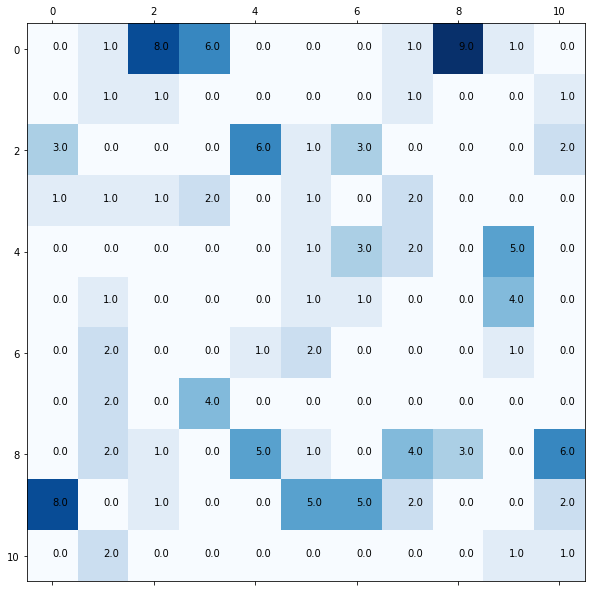

In [46]:
plt.rc('figure', figsize=[10,10])
plt.matshow(confusion_matrix,cmap='Blues')
for i in range(0,confusion_matrix.shape[0]):
    for j in range(0,confusion_matrix.shape[1]):
        plt.annotate(confusion_matrix[i,j],(j,i))
        
# Calculate Accuracy
print("Overall accuracy: ",(np.sum(np.diag(confusion_matrix)))/np.sum(confusion_matrix))